In [1]:
import pickle
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import integrate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPool1D, Conv2D, MaxPool2D,BatchNormalization, GRU
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import SimpleRNN
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Download the Dataset

In [3]:
import os
os.chdir('/content/drive/MyDrive/RML2016_dataset/') 
Data = pickle.load(open("RML2016.10b.dat",'rb'), encoding = 'bytes')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Data.keys())))), [1,0])

In [4]:
print(f"Mods: {mods}")
print(f"SNRs: {snrs}")

Mods: [b'8PSK', b'AM-DSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM']
SNRs: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [5]:
X = []     
label = []
snr_mod_labels = []
for snr in snrs:
  x = []
  y = []
  curr_snr_labels = []
  for mod in mods:
    x.append(Data[(mod,snr)])
    y.append([mod] * Data[(mod,snr)].shape[0])
    curr_snr_labels.append([snr, mod] * Data[(mod,snr)].shape[0])
  y = np.array(y)
  curr_snr_labels = np.array(curr_snr_labels)
  label.append(y.reshape((y.shape[0] * y.shape[1])))
  snr_mod_labels.append(curr_snr_labels.reshape((int(curr_snr_labels.shape[1]/2) * curr_snr_labels.shape[0], 2)))
  X.append(np.vstack(x))
label = np.array(label)
X = np.array(X)
snr_mod_labels = np.array(snr_mod_labels)

In [6]:
print(X.shape)
print(label.shape)
print(snr_mod_labels.shape)

(20, 60000, 2, 128)
(20, 60000)
(20, 60000, 2)


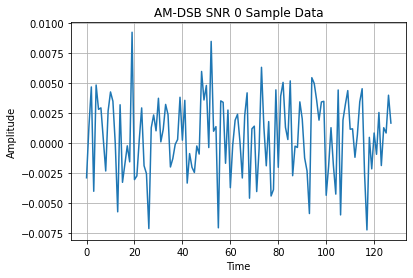

In [7]:
plt.plot(Data[b'AM-DSB',0][2,0])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("AM-DSB SNR 0 Sample Data")
plt.grid(b=True, axis='both')

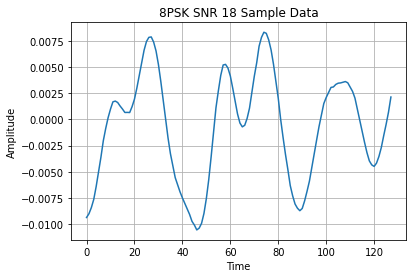

In [8]:
plt.plot(Data[b'8PSK',18][2,0])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("8PSK SNR 18 Sample Data")
plt.grid(b=True, axis='both')

## Data Splitting And Balancing

In [9]:
#Reshaping dataset
samples = X.reshape((X.shape[0] * X.shape[1], X.shape[2], X.shape[3], 1))
labels = snr_mod_labels.reshape((-1, 2)) # Notic that the labels are at this format [snr, modulation]

In [10]:
print('samples shape:', samples.shape)
print('labels shape:', labels.shape)

samples shape: (1200000, 2, 128, 1)
labels shape: (1200000, 2)


In [11]:
#Splitting data
training_val_data, testing_data, training_val_pair_labels, testing_pair_labels = train_test_split(samples, labels,stratify=labels, shuffle=True, test_size=0.3)
training_data, validation_data, training_pair_labels, validation_pair_labels =  train_test_split(training_val_data, training_val_pair_labels,stratify=training_val_pair_labels, shuffle=True, test_size=0.05)

In [12]:
training_labels = training_pair_labels[:, 1]
validation_labels = validation_pair_labels[:, 1]

In [13]:
print('training data shape:', training_data.shape)
print('training labels shape:', training_labels.shape)
print('validation data shape:', validation_data.shape)
print('validation labels shape:', validation_labels.shape)
print('testing data shape:', testing_data.shape)
print('testing labels shape:', testing_pair_labels.shape)

training data shape: (798000, 2, 128, 1)
training labels shape: (798000,)
validation data shape: (42000, 2, 128, 1)
validation labels shape: (42000,)
testing data shape: (360000, 2, 128, 1)
testing labels shape: (360000, 2)


In [14]:
unique, counts = np.unique(training_labels, return_counts=True)
print('training:\t', dict(zip(unique, counts)))
unique, counts = np.unique(validation_labels, return_counts=True)
print('validation:\t', dict(zip(unique, counts)))
unique, counts = np.unique(testing_pair_labels, return_counts=True)
print('testing:\t', dict(zip(unique, counts)))

training:	 {b'8PSK': 79800, b'AM-DSB': 79800, b'BPSK': 79800, b'CPFSK': 79800, b'GFSK': 79800, b'PAM4': 79800, b'QAM16': 79800, b'QAM64': 79800, b'QPSK': 79800, b'WBFM': 79800}
validation:	 {b'8PSK': 4200, b'AM-DSB': 4200, b'BPSK': 4200, b'CPFSK': 4200, b'GFSK': 4200, b'PAM4': 4200, b'QAM16': 4200, b'QAM64': 4200, b'QPSK': 4200, b'WBFM': 4200}
testing:	 {b'-10': 18000, b'-12': 18000, b'-14': 18000, b'-16': 18000, b'-18': 18000, b'-2': 18000, b'-20': 18000, b'-4': 18000, b'-6': 18000, b'-8': 18000, b'0': 18000, b'10': 18000, b'12': 18000, b'14': 18000, b'16': 18000, b'18': 18000, b'2': 18000, b'4': 18000, b'6': 18000, b'8': 18000, b'8PSK': 36000, b'AM-DSB': 36000, b'BPSK': 36000, b'CPFSK': 36000, b'GFSK': 36000, b'PAM4': 36000, b'QAM16': 36000, b'QAM64': 36000, b'QPSK': 36000, b'WBFM': 36000}


In [15]:
# converting labels to one hot encoding
training_onehot = OneHotEncoder(sparse = False).fit_transform(training_labels.reshape(-1,1))
validation_onehot = OneHotEncoder(sparse = False).fit_transform(validation_labels.reshape(-1,1))

In [16]:
print('training onehot encoding shape:', training_onehot.shape)
print('validation onehot encoding shape:', validation_onehot.shape)

training onehot encoding shape: (798000, 10)
validation onehot encoding shape: (42000, 10)


## Scoring functions

In [17]:
def model_pred_and_accuracy(model, testing_data, testing_labels):
  pred = model.predict(testing_data)
  decoded_pred = np.argmax(pred, axis=1)
  testing_labels = np.argmax(testing_labels, axis=1)

  return pred, accuracy_score(testing_labels, decoded_pred)

In [18]:
def confusion_matrixf(pred, actual, title):
  actual_decode = np.argmax(actual, axis=1)
  pred_decode = np.argmax(pred, axis=1)
  confusion_mtx = confusion_matrix(actual_decode, pred_decode)
  plt.figure(figsize=(10, 8))
  sns.heatmap(confusion_mtx, xticklabels=mods, yticklabels=mods, annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
  plt.title(title)
  plt.show()

In [19]:
def model_scoring(model, testing_data, testing_pair_labels):
  sorted_idx = testing_pair_labels[:, 0].astype(int).argsort() # sort by snr value
  testing_data = testing_data[sorted_idx] # to sort samples by snr
  testing_pair_labels = testing_pair_labels[sorted_idx] # to sort labels by snr

  SNRs = testing_pair_labels[:, 0]
  modulations = testing_pair_labels[:, 1]
  unique_snr, snr_count = np.unique(SNRs, return_counts=True)
  snr_count_dict = dict(zip(unique, counts))


  curr_sample = 0
  for snr in range(len(unique_snr)):
    curr_snr = SNRs[curr_sample]
    curr_snr_samples = []
    curr_snr_labels = []
    for j in range(snr_count_dict[curr_snr]):
      curr_snr_samples.append(testing_data[curr_sample])
      curr_snr_labels.append(modulations[curr_sample])
      curr_sample += 1

    curr_snr_samples = np.array(curr_snr_samples)
    curr_snr_labels = np.array(curr_snr_labels)
    onehot_labels = OneHotEncoder(sparse = False).fit_transform(curr_snr_labels.reshape(-1,1))

    pred, accuracy = model_pred_and_accuracy(model, curr_snr_samples, onehot_labels)
    print('Accuracy at SNR = ' + curr_snr.decode() + ' is ' + str(accuracy) + '%')
    confusion_matrixf(pred, onehot_labels, 'SNR: ' + curr_snr.decode())

## CNN Model

In [23]:
learning_rate = 0.001
batch_size = 512
epochs = 200

In [21]:
cnn_model = Sequential()
cnn_model.add(Conv2D(256, 3, activation='relu', padding='same'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Conv2D(64, 3, strides=2, activation='relu', padding='same'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu' ))
cnn_model.add(Dense(10,  activation='softmax'))
cnn_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [24]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True,)
checkpointer = ModelCheckpoint(filepath='saved_models/classification.hdf5', verbose=1, save_best_only=True)

with tf.device('/device:GPU:0'):
  history = cnn_model.fit(training_data, training_onehot, batch_size=batch_size, epochs=epochs, validation_data=(validation_data, validation_onehot), callbacks=[es, checkpointer], verbose=1)

Epoch 1/200
1559/1559 [==============================] - ETA: 0s - loss: 1.1543 - accuracy: 0.5219
Epoch 1: val_loss improved from inf to 1.11128, saving model to saved_models/classification.hdf5
1559/1559 [==============================] - 67s 43ms/step - loss: 1.1543 - accuracy: 0.5219 - val_loss: 1.1113 - val_accuracy: 0.5392
Epoch 2/200
1559/1559 [==============================] - ETA: 0s - loss: 1.1457 - accuracy: 0.5254
Epoch 2: val_loss improved from 1.11128 to 1.10194, saving model to saved_models/classification.hdf5
1559/1559 [==============================] - 67s 43ms/step - loss: 1.1457 - accuracy: 0.5254 - val_loss: 1.1019 - val_accuracy: 0.5354
Epoch 3/200
1559/1559 [==============================] - ETA: 0s - loss: 1.1287 - accuracy: 0.5305
Epoch 3: val_loss improved from 1.10194 to 1.09171, saving model to saved_models/classification.hdf5
1559/1559 [==============================] - 66s 43ms/step - loss: 1.1287 - accuracy: 0.5305 - val_loss: 1.0917 - val_accuracy: 0.5424

Accuracy at SNR = -20 is 0.10444444444444445%


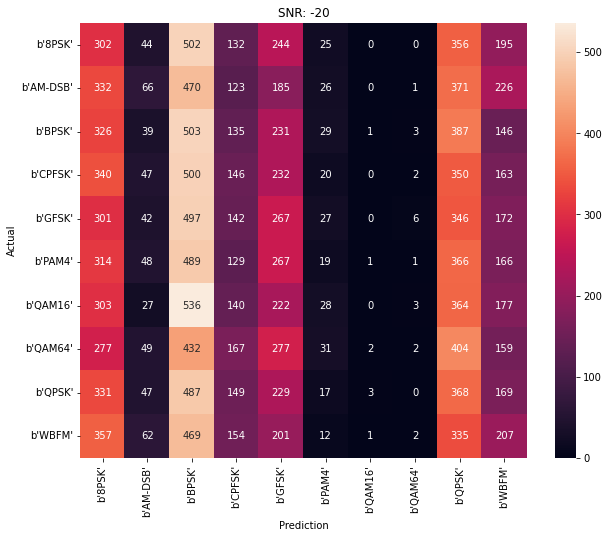

Accuracy at SNR = -18 is 0.10744444444444444%


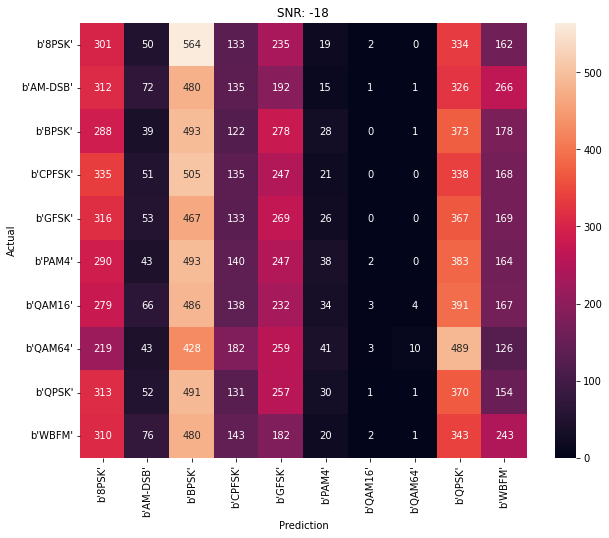

Accuracy at SNR = -16 is 0.116%


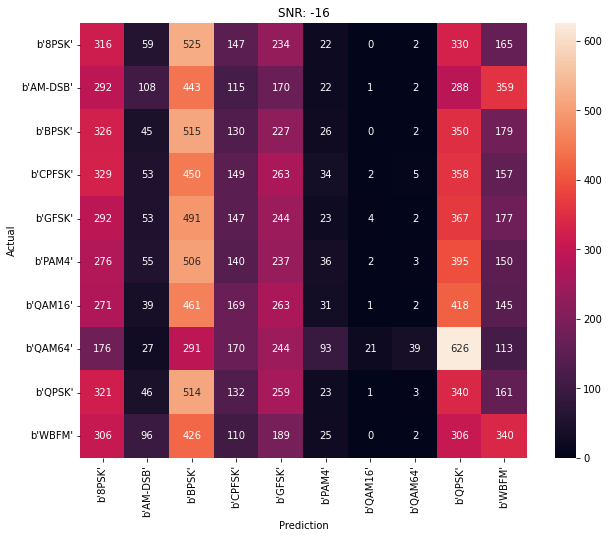

Accuracy at SNR = -14 is 0.14333333333333334%


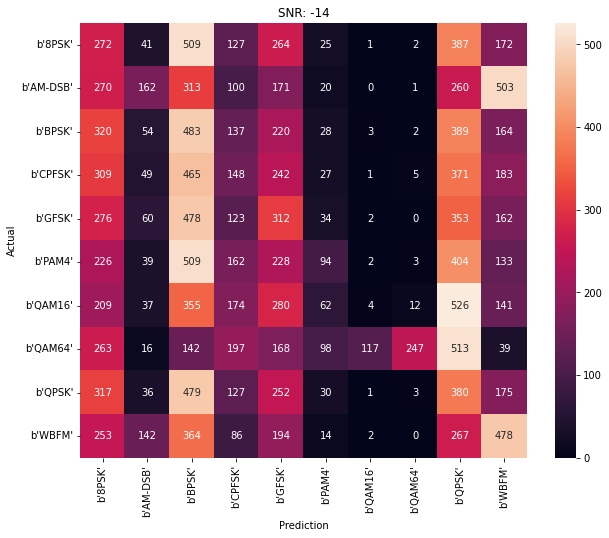

Accuracy at SNR = -12 is 0.18933333333333333%


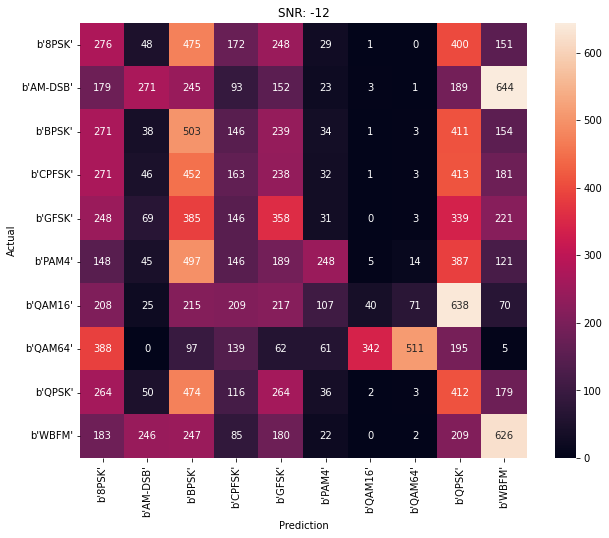

Accuracy at SNR = -10 is 0.25416666666666665%


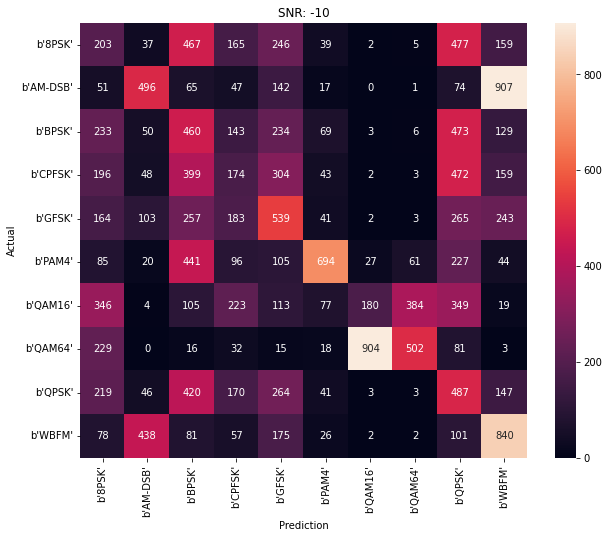

Accuracy at SNR = -8 is 0.3605%


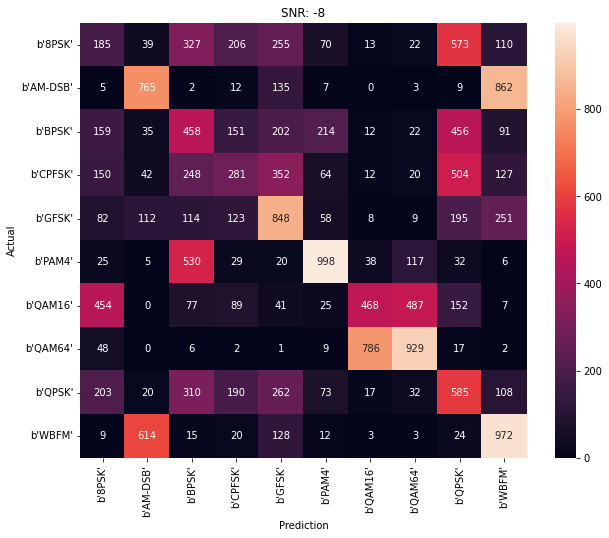

Accuracy at SNR = -6 is 0.5016666666666667%


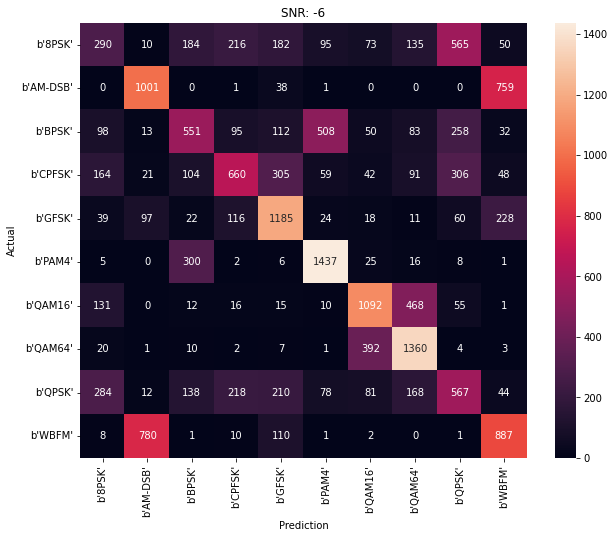

Accuracy at SNR = -4 is 0.6129444444444444%


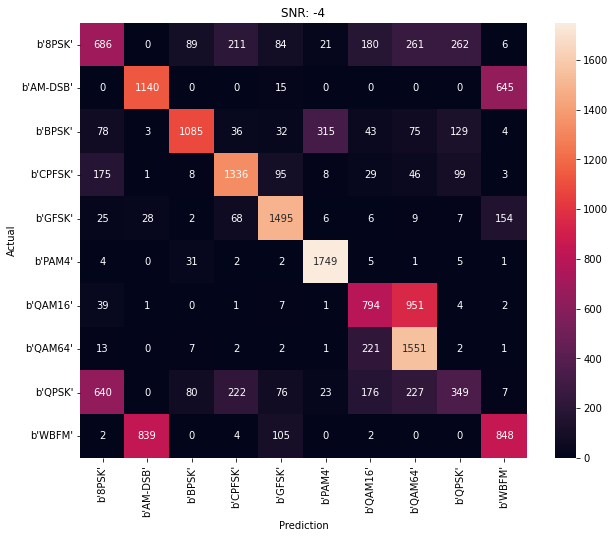

Accuracy at SNR = -2 is 0.7127777777777777%


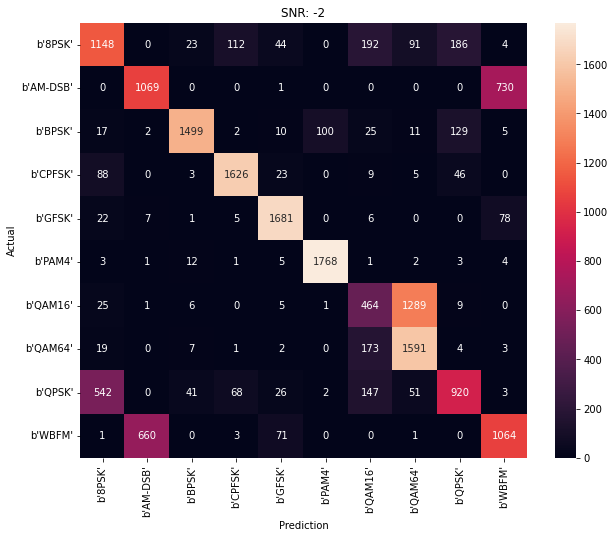

Accuracy at SNR = 0 is 0.7815%


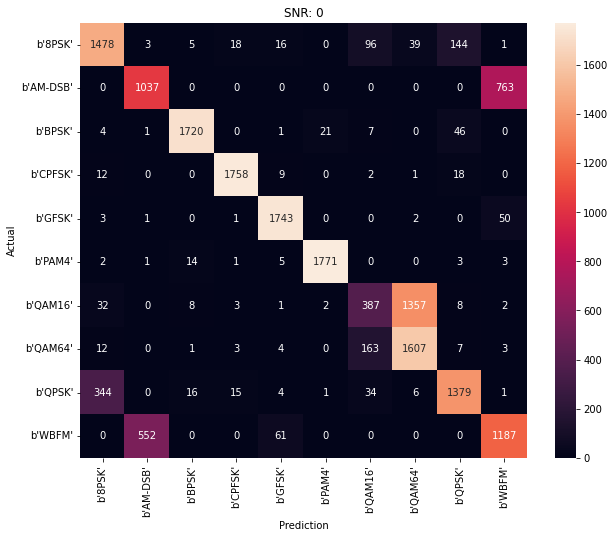

Accuracy at SNR = 2 is 0.8083333333333333%


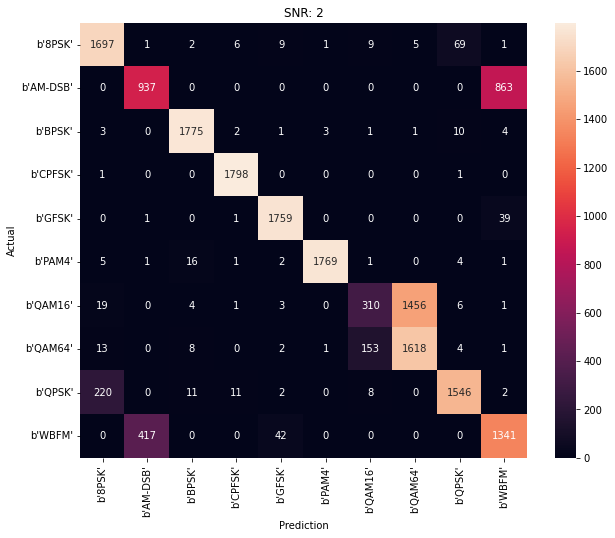

Accuracy at SNR = 4 is 0.8116111111111111%


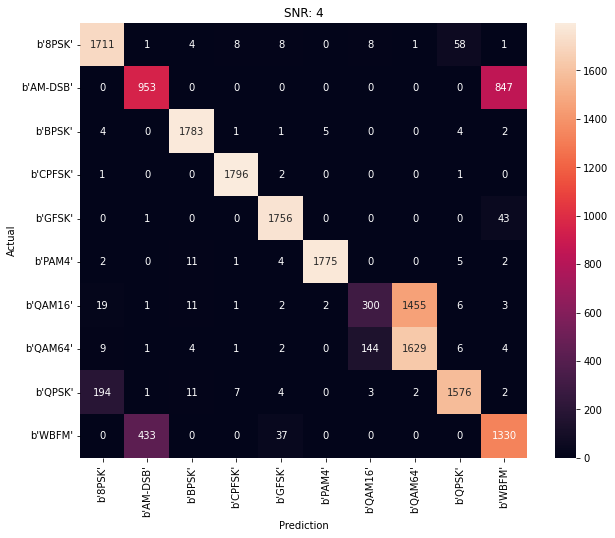

Accuracy at SNR = 6 is 0.8191111111111111%


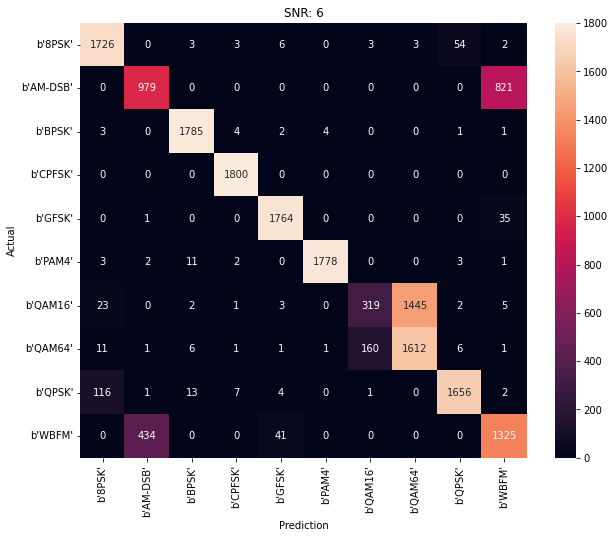

Accuracy at SNR = 8 is 0.8188888888888889%


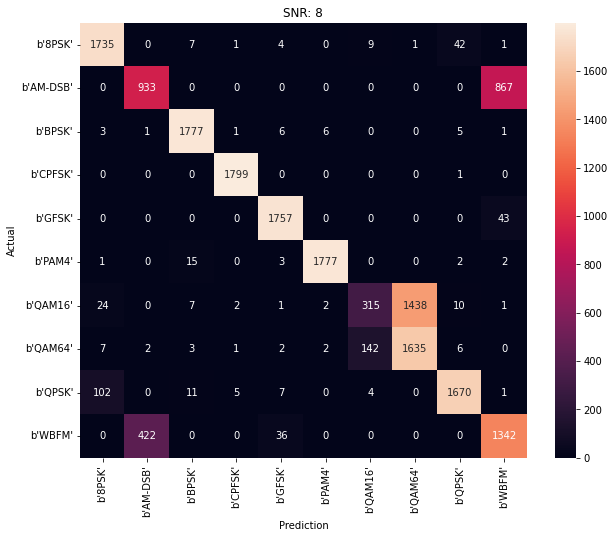

Accuracy at SNR = 10 is 0.8222777777777778%


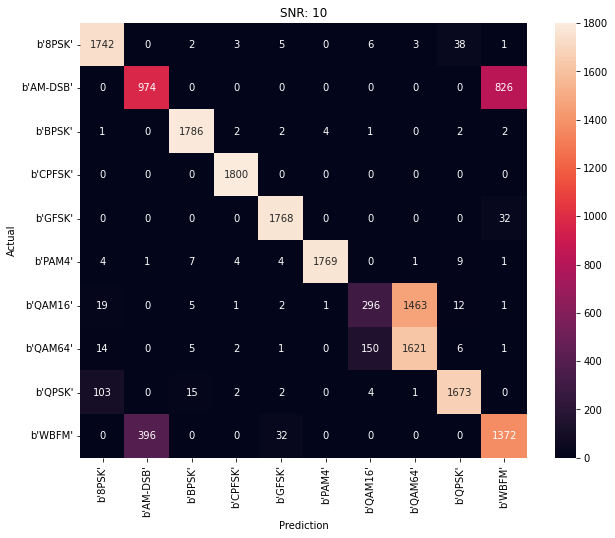

Accuracy at SNR = 12 is 0.8202777777777778%


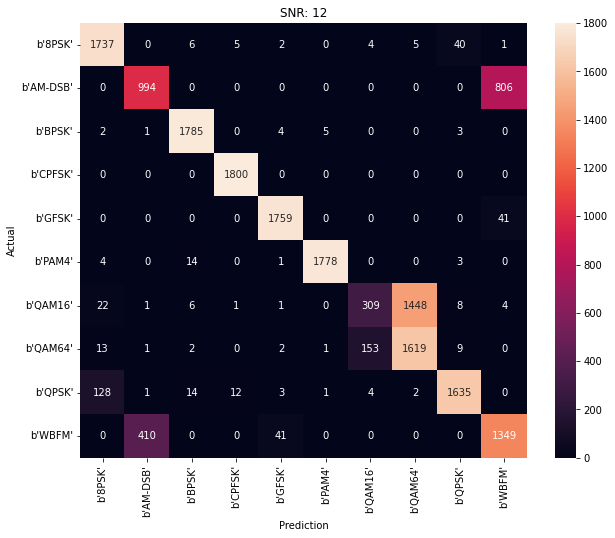

Accuracy at SNR = 14 is 0.8191111111111111%


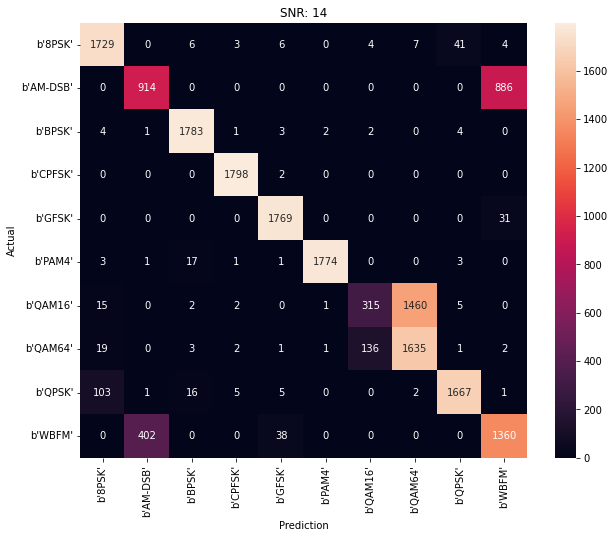

Accuracy at SNR = 16 is 0.8261666666666667%


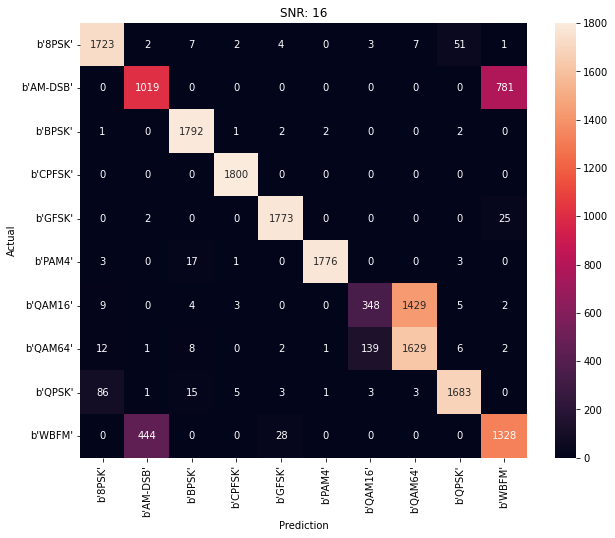

Accuracy at SNR = 18 is 0.8187777777777778%


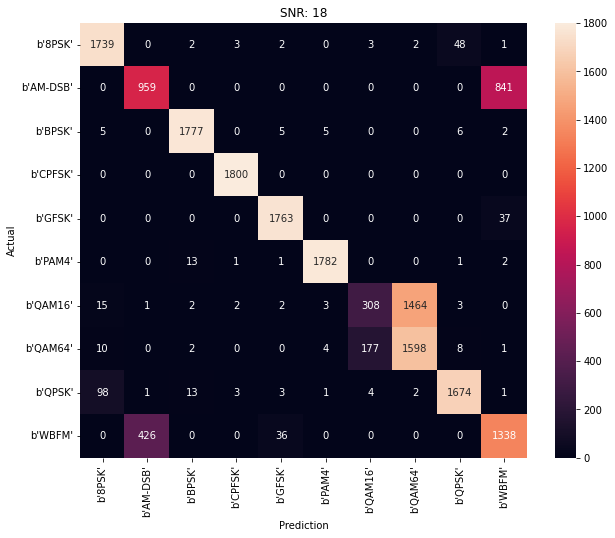

In [25]:
model_scoring(cnn_model, testing_data, testing_pair_labels)

## RNN Model

In [ ]:
rnn_training_data = training_data.reshape(training_data.shape[0], training_data.shape[1], training_data.shape[2])
rnn_validation_data = validation_data.reshape(validation_data.shape[0], validation_data.shape[1], validation_data.shape[2])
rnn_testing_data = testing_data.reshape(testing_data.shape[0], testing_data.shape[1], testing_data.shape[2])

In [ ]:
print('training data shape:', rnn_training_data.shape)
print('validation data shape:', rnn_validation_data.shape)
print('testing data shape:', rnn_testing_data.shape)

training data shape: (798000, 2, 128)
validation data shape: (42000, 2, 128)
testing data shape: (360000, 2, 128)


In [ ]:
learning_rate = 0.001
batch_size = 512
epochs = 200

In [ ]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(128, activation='relu'))
#rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(10, activation='softmax'))
rnn_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True,)
checkpointer = ModelCheckpoint(filepath='saved_models/rnn_classification.hdf5', verbose=1, save_best_only=True)

with tf.device('/device:GPU:0'):
  history = rnn_model.fit(rnn_training_data, training_onehot, batch_size=batch_size, epochs=epochs, validation_data=(rnn_validation_data, validation_onehot), callbacks=[es, checkpointer], verbose=1)

Epoch 1/200
1557/1559 [============================>.] - ETA: 0s - loss: 1.8737 - accuracy: 0.2652
Epoch 1: val_loss improved from inf to 1.73964, saving model to saved_models/rnn_classification.hdf5
1559/1559 [==============================] - 12s 6ms/step - loss: 1.8736 - accuracy: 0.2653 - val_loss: 1.7396 - val_accuracy: 0.3085
Epoch 2/200
1556/1559 [============================>.] - ETA: 0s - loss: 1.6991 - accuracy: 0.3237
Epoch 2: val_loss improved from 1.73964 to 1.66907, saving model to saved_models/rnn_classification.hdf5
1559/1559 [==============================] - 9s 6ms/step - loss: 1.6990 - accuracy: 0.3237 - val_loss: 1.6691 - val_accuracy: 0.3327
Epoch 3/200
1556/1559 [============================>.] - ETA: 0s - loss: 1.6489 - accuracy: 0.3438
Epoch 3: val_loss improved from 1.66907 to 1.63783, saving model to saved_models/rnn_classification.hdf5
1559/1559 [==============================] - 9s 5ms/step - loss: 1.6489 - accuracy: 0.3438 - val_loss: 1.6378 - val_accuracy:

Accuracy at SNR = -20 is 0.10522222222222222%


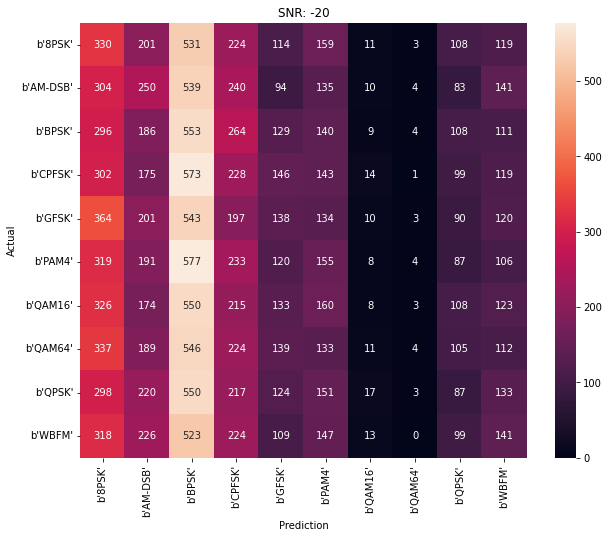

Accuracy at SNR = -18 is 0.11072222222222222%


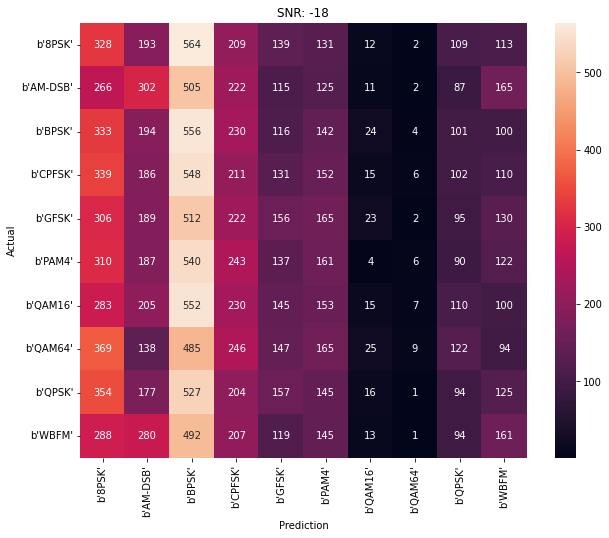

Accuracy at SNR = -16 is 0.12055555555555555%


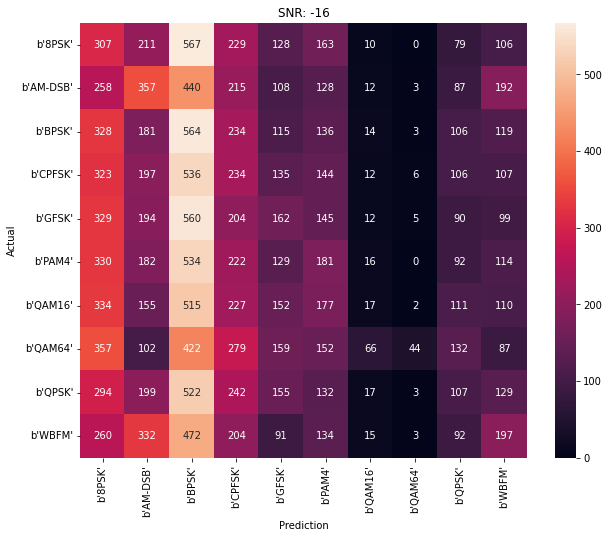

Accuracy at SNR = -14 is 0.1376111111111111%


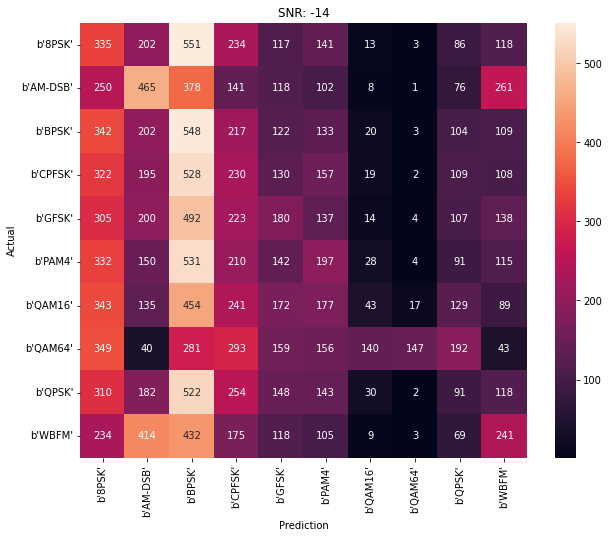

Accuracy at SNR = -12 is 0.18388888888888888%


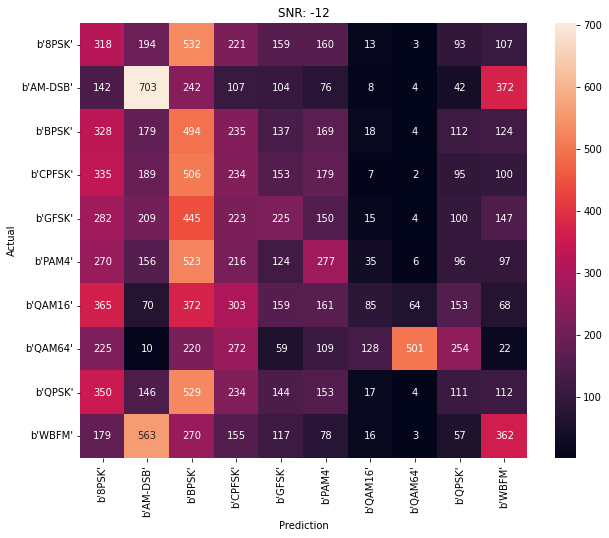

Accuracy at SNR = -10 is 0.25144444444444447%


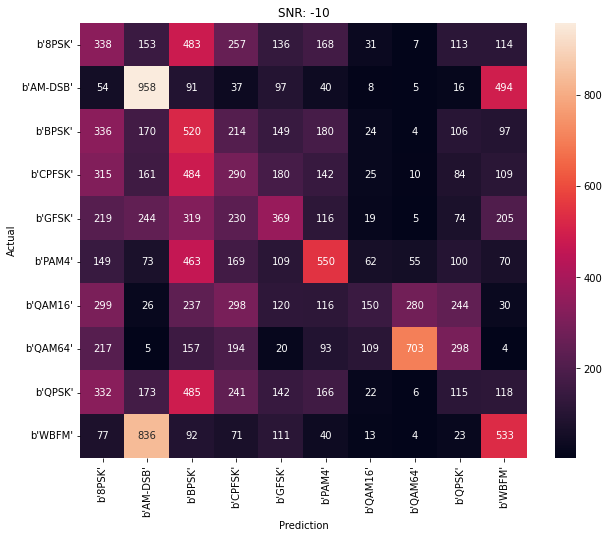

Accuracy at SNR = -8 is 0.3121111111111111%


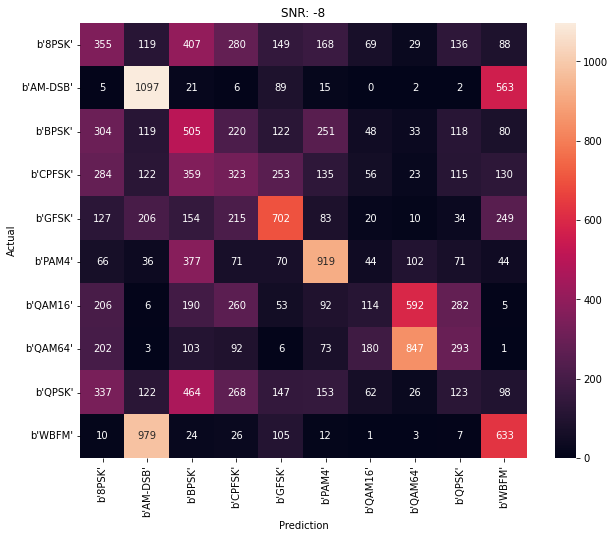

Accuracy at SNR = -6 is 0.37155555555555553%


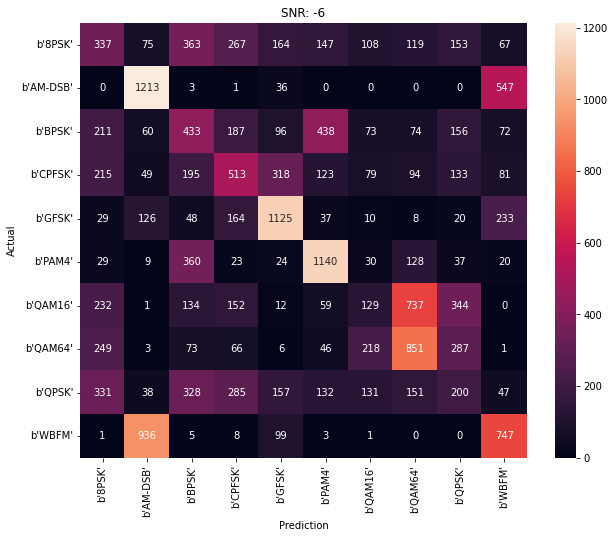

Accuracy at SNR = -4 is 0.44583333333333336%


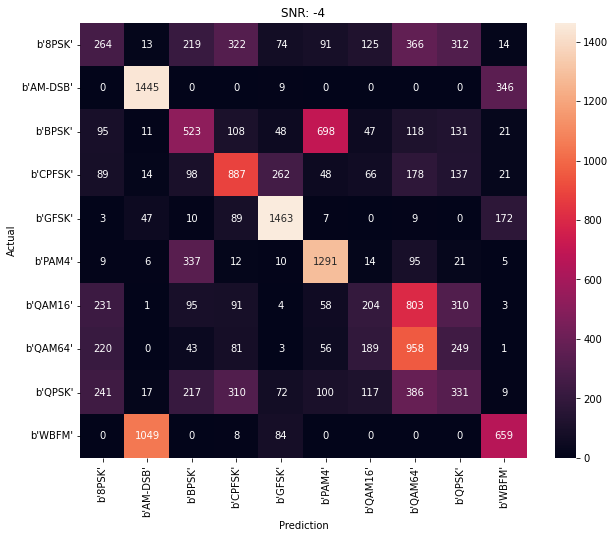

Accuracy at SNR = -2 is 0.5077222222222222%


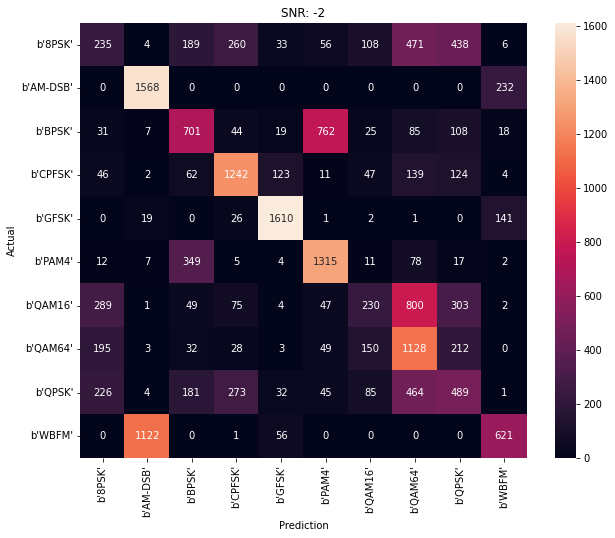

Accuracy at SNR = 0 is 0.5748888888888889%


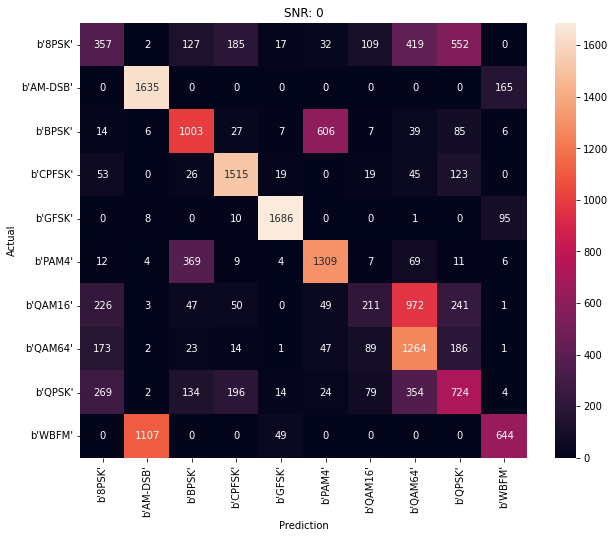

Accuracy at SNR = 2 is 0.6295555555555555%


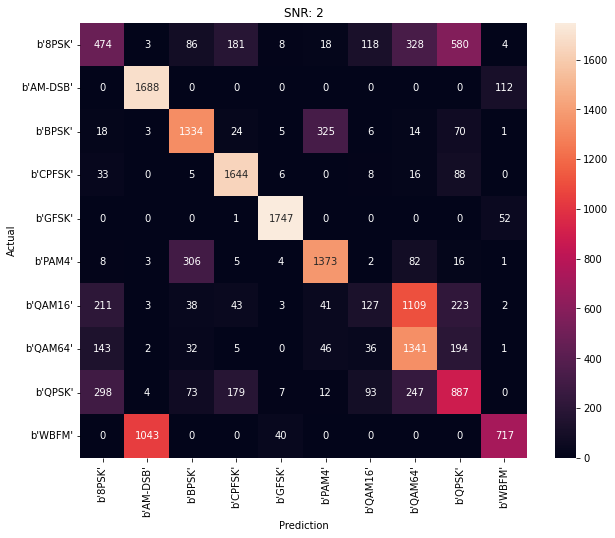

Accuracy at SNR = 4 is 0.6520555555555556%


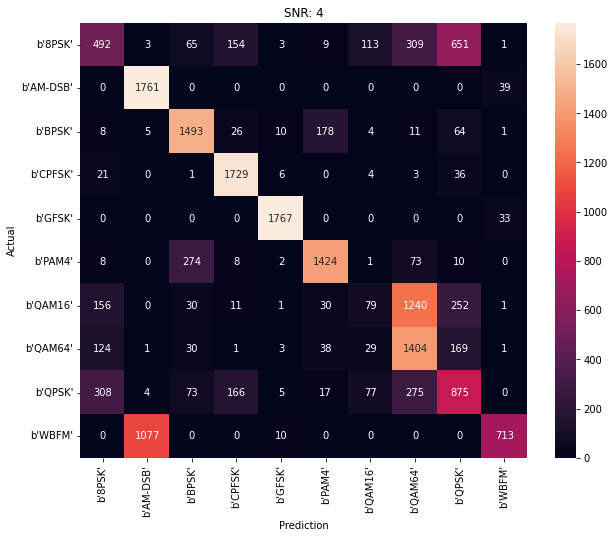

Accuracy at SNR = 6 is 0.668%


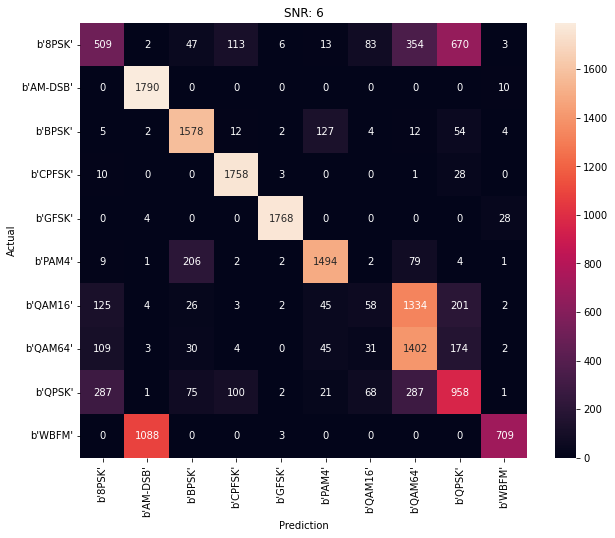

Accuracy at SNR = 8 is 0.6688888888888889%


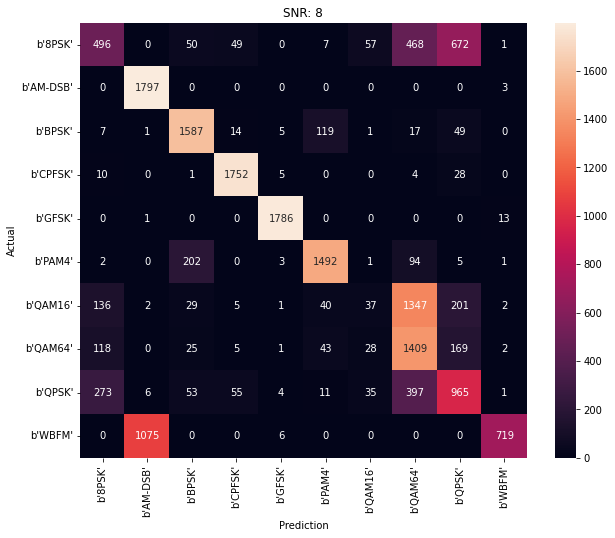

Accuracy at SNR = 10 is 0.6631111111111111%


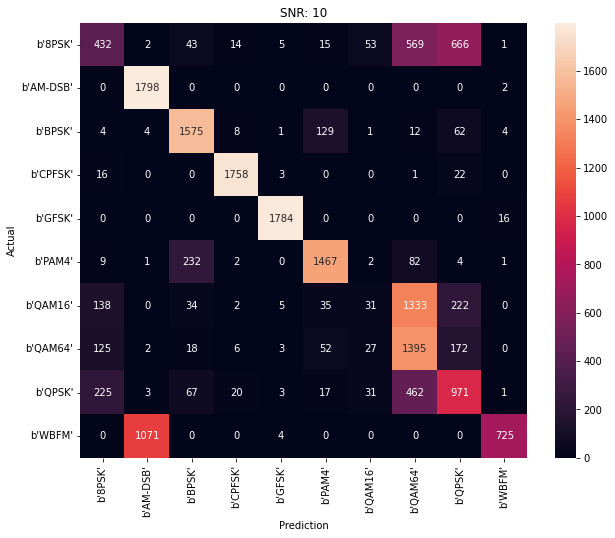

Accuracy at SNR = 12 is 0.6692222222222223%


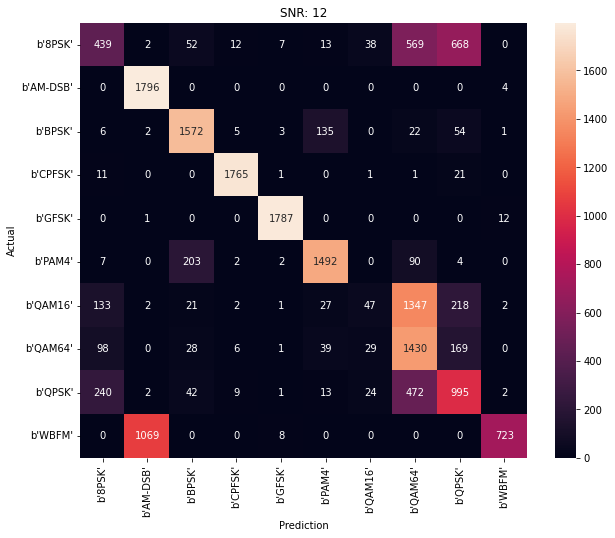

Accuracy at SNR = 14 is 0.6633888888888889%


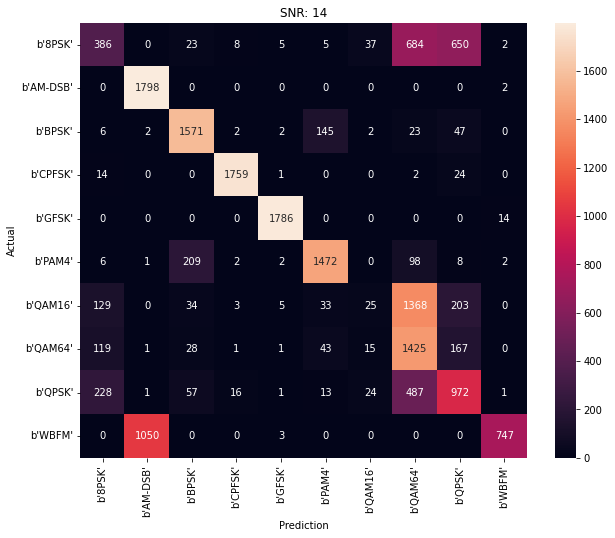

Accuracy at SNR = 16 is 0.6667777777777778%


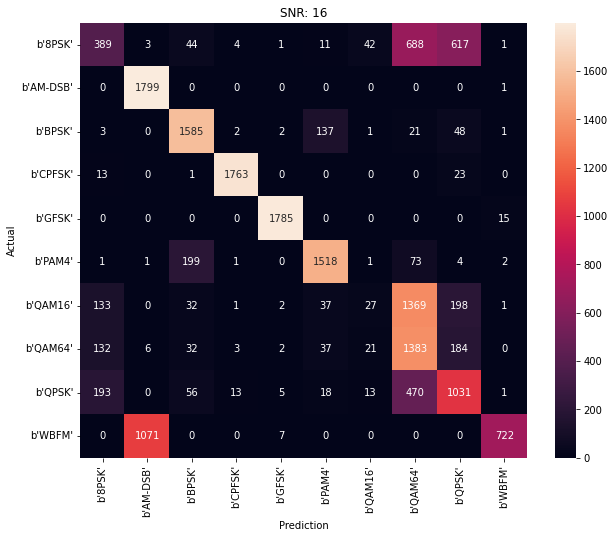

Accuracy at SNR = 18 is 0.6646111111111112%


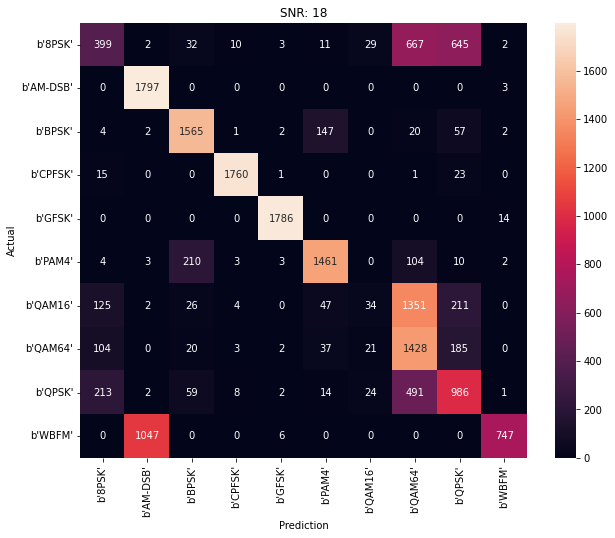

In [ ]:
model_scoring(rnn_model, testing_data, testing_pair_labels)

## LSTM Model

In [ ]:
lstm_training_data = training_data.reshape(training_data.shape[0], training_data.shape[1], training_data.shape[2])
lstm_validation_data = validation_data.reshape(validation_data.shape[0], validation_data.shape[1], validation_data.shape[2])
lstm_testing_data = testing_data.reshape(testing_data.shape[0], testing_data.shape[1], testing_data.shape[2])

In [ ]:
print('training data shape:', lstm_training_data.shape)
print('validation data shape:', lstm_validation_data.shape)
print('testing data shape:', lstm_testing_data.shape)

training data shape: (798000, 2, 128)
validation data shape: (42000, 2, 128)
testing data shape: (360000, 2, 128)


In [ ]:
learning_rate = 0.001
batch_size = 128
epochs = 200

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(256))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(10, activation='softmax'))
lstm_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True,)
checkpointer = ModelCheckpoint(filepath='saved_models/lstm_classification.hdf5', verbose=1, save_best_only=True)

with tf.device('/device:GPU:0'):
  history = lstm_model.fit(lstm_training_data, training_onehot, batch_size=batch_size, epochs=epochs, validation_data=(lstm_validation_data, validation_onehot), callbacks=[es, checkpointer], verbose=1)

Epoch 1/200
6234/6235 [============================>.] - ETA: 0s - loss: 2.0485 - accuracy: 0.2028
Epoch 1: val_loss improved from inf to 1.98755, saving model to saved_models/lstm_classification.hdf5
6235/6235 [==============================] - 29s 4ms/step - loss: 2.0485 - accuracy: 0.2028 - val_loss: 1.9875 - val_accuracy: 0.2315
Epoch 2/200
6223/6235 [============================>.] - ETA: 0s - loss: 1.9333 - accuracy: 0.2497
Epoch 2: val_loss improved from 1.98755 to 1.85009, saving model to saved_models/lstm_classification.hdf5
6235/6235 [==============================] - 26s 4ms/step - loss: 1.9332 - accuracy: 0.2497 - val_loss: 1.8501 - val_accuracy: 0.2726
Epoch 3/200
6229/6235 [============================>.] - ETA: 0s - loss: 1.7825 - accuracy: 0.2951
Epoch 3: val_loss improved from 1.85009 to 1.70669, saving model to saved_models/lstm_classification.hdf5
6235/6235 [==============================] - 26s 4ms/step - loss: 1.7825 - accuracy: 0.2951 - val_loss: 1.7067 - val_accu

Accuracy at SNR = -20 is 0.105%


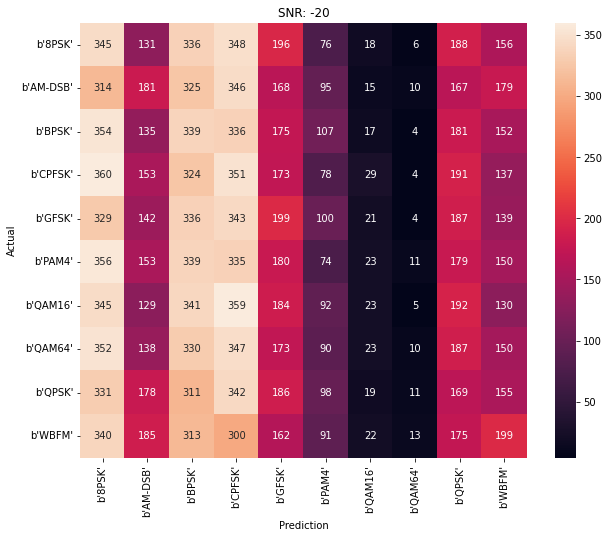

Accuracy at SNR = -18 is 0.10544444444444444%


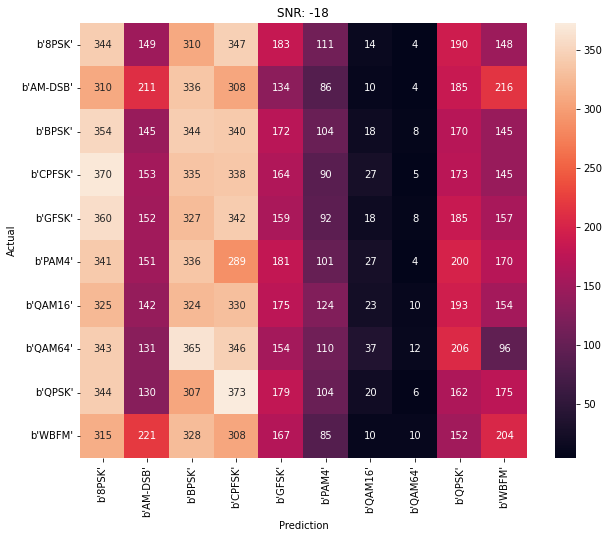

Accuracy at SNR = -16 is 0.11916666666666667%


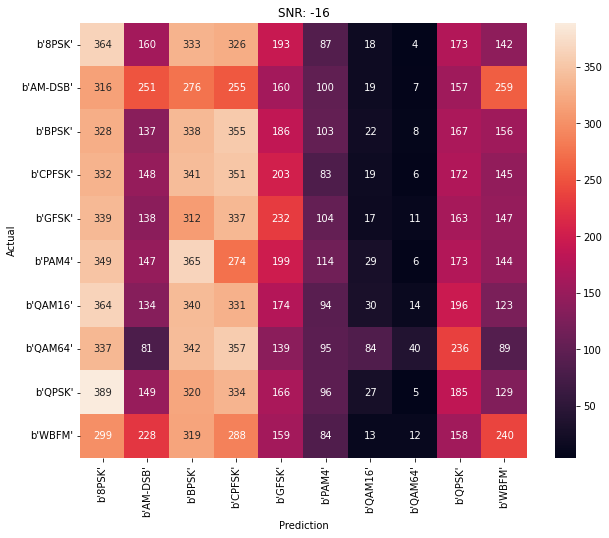

Accuracy at SNR = -14 is 0.13127777777777777%


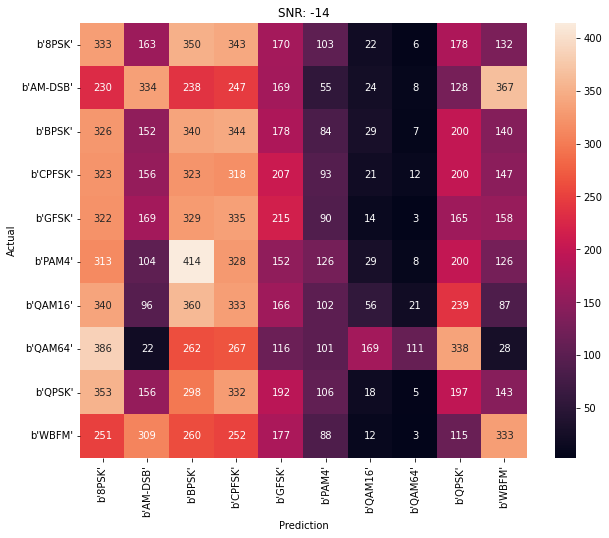

Accuracy at SNR = -12 is 0.16455555555555557%


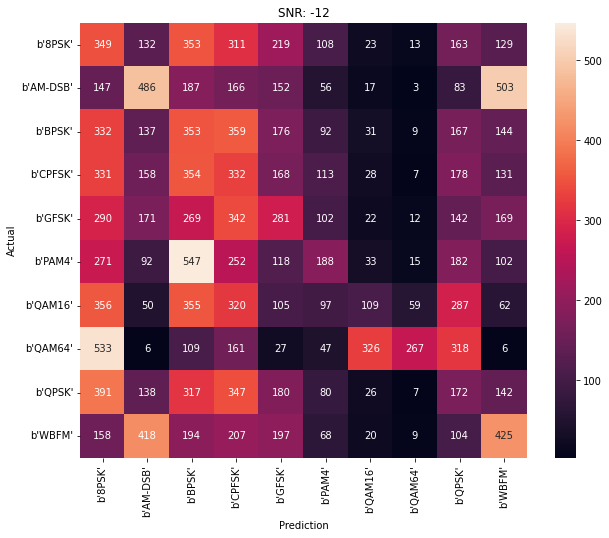

Accuracy at SNR = -10 is 0.22894444444444445%


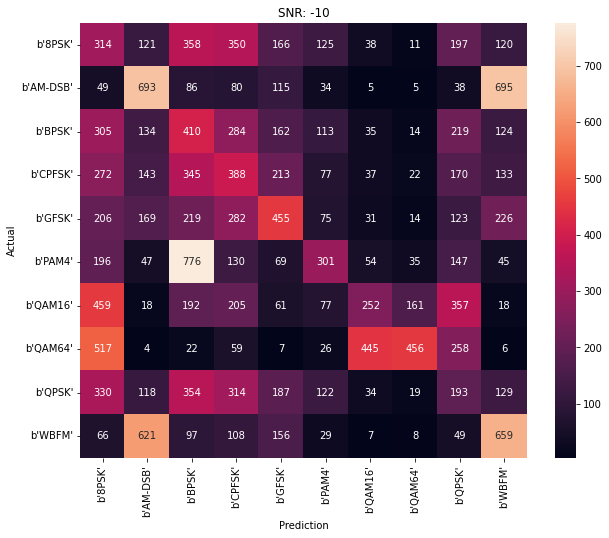

Accuracy at SNR = -8 is 0.3201111111111111%


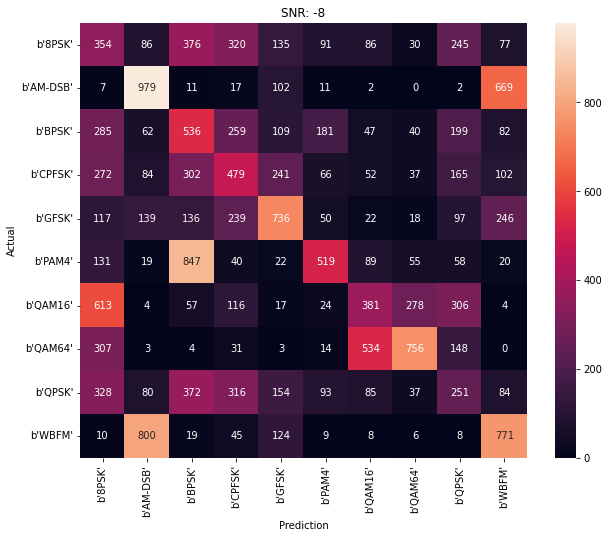

Accuracy at SNR = -6 is 0.41955555555555557%


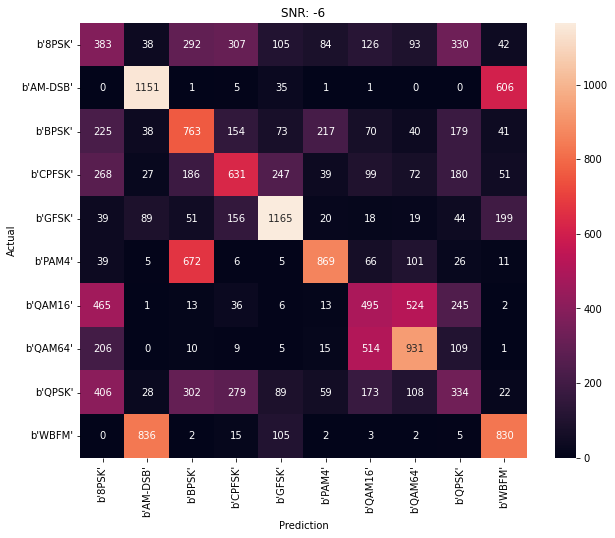

Accuracy at SNR = -4 is 0.5380555555555555%


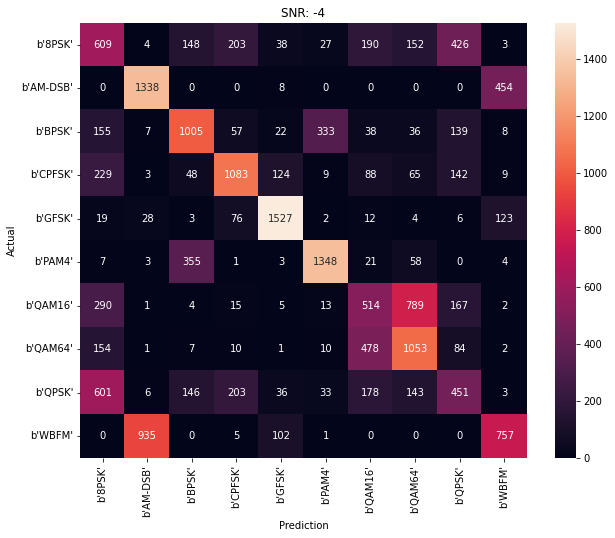

Accuracy at SNR = -2 is 0.6117777777777778%


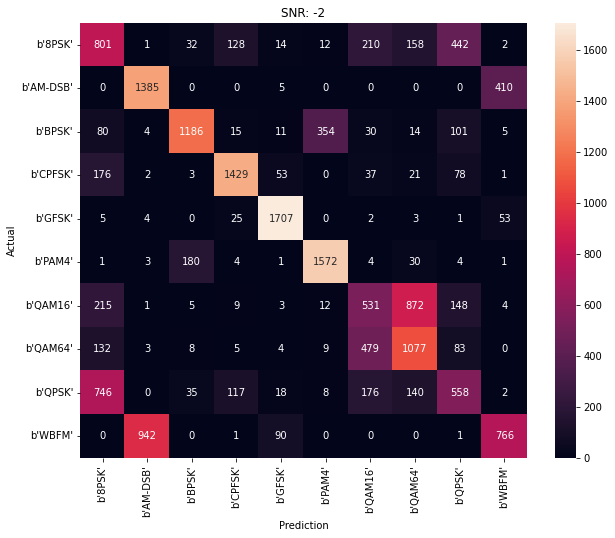

Accuracy at SNR = 0 is 0.6622777777777777%


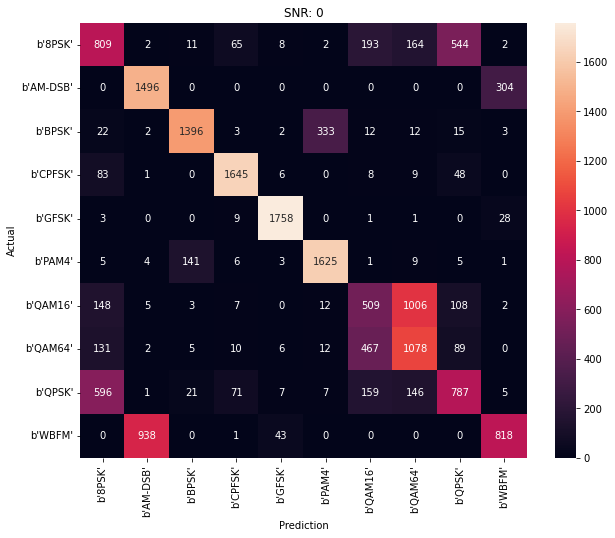

Accuracy at SNR = 2 is 0.6919444444444445%


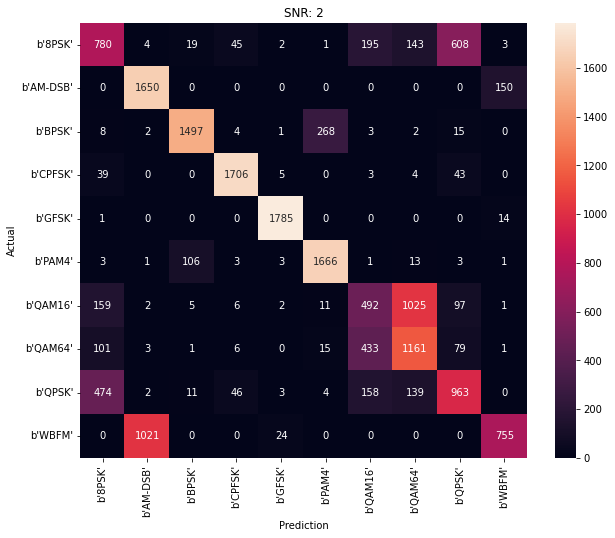

Accuracy at SNR = 4 is 0.6976111111111111%


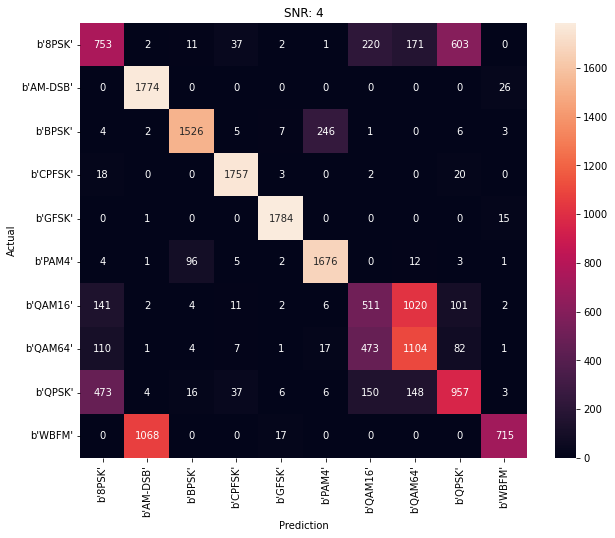

Accuracy at SNR = 6 is 0.7072222222222222%


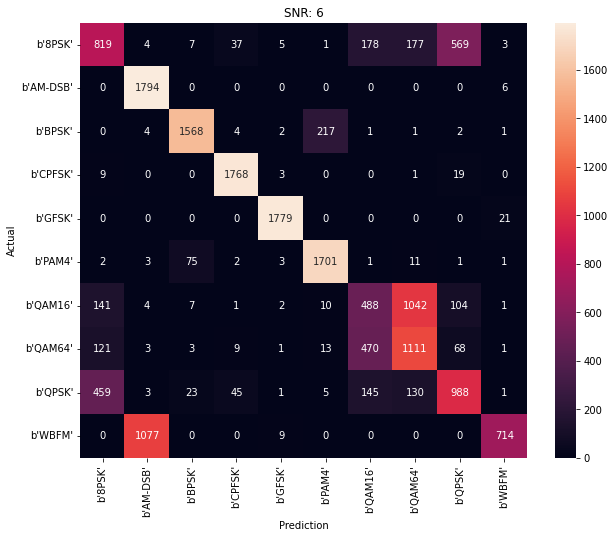

Accuracy at SNR = 8 is 0.704%


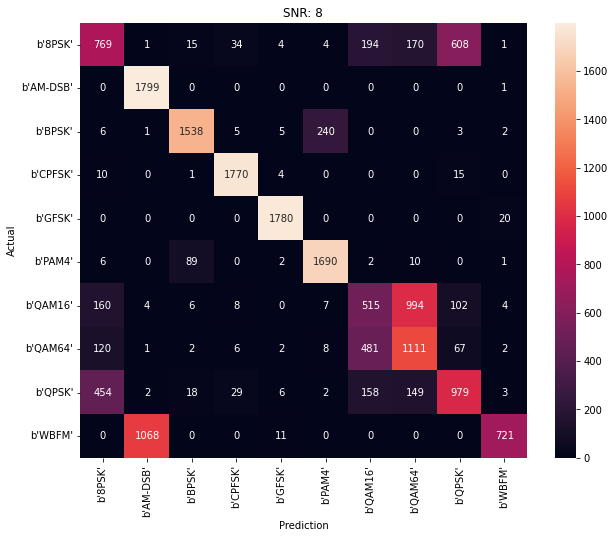

Accuracy at SNR = 10 is 0.7068888888888889%


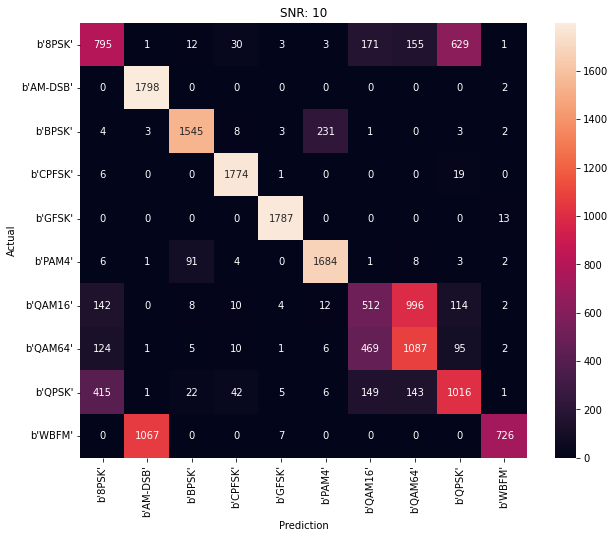

Accuracy at SNR = 12 is 0.7064444444444444%


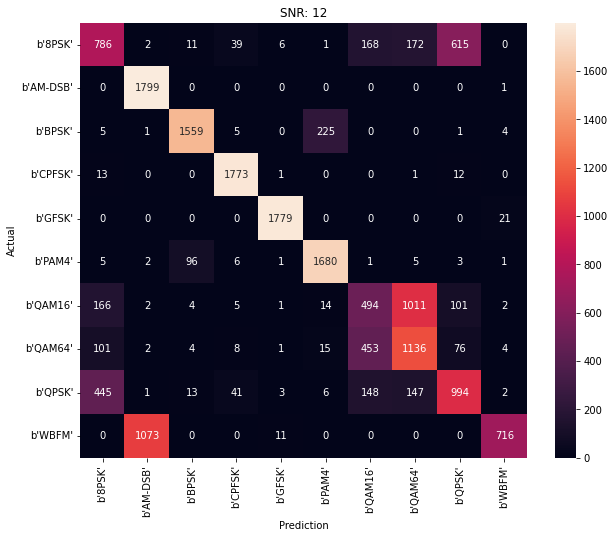

Accuracy at SNR = 14 is 0.7079444444444445%


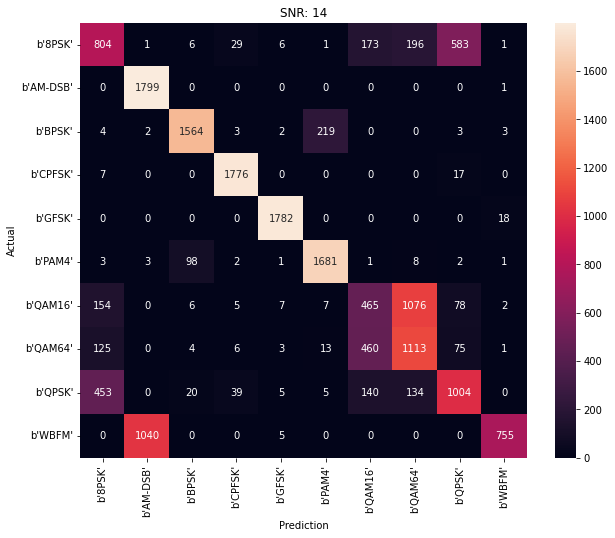

Accuracy at SNR = 16 is 0.7078333333333333%


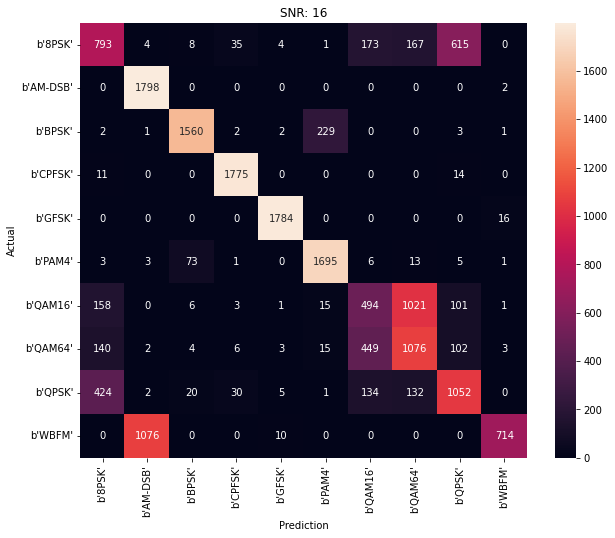

Accuracy at SNR = 18 is 0.7102777777777778%


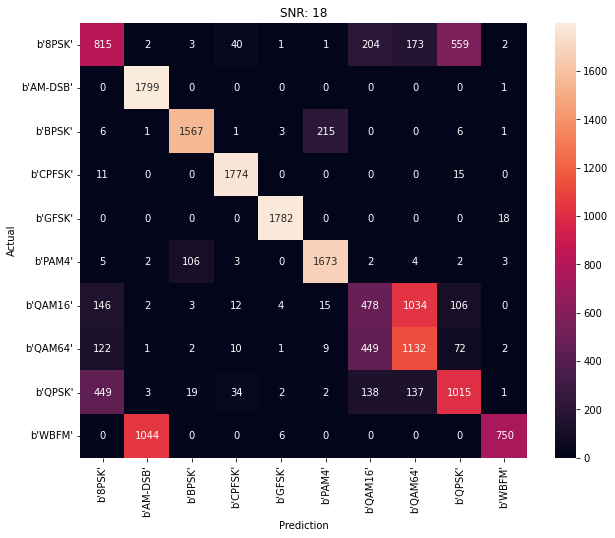

In [ ]:
model_scoring(lstm_model, testing_data, testing_pair_labels)